**Classifying diseases based on the gut micobiota (GM) data with reduced dimesionality**

In this notebook file, we will demonstrate how genus-level data can be used to classify diseases using machine learning algorithms. Here, we will be using four machine learning (ML) algorithms, including random forest (RF), support vector machine (SVM), artificial neural networks (ANN), and convolutional neural networks (CNN). We will use both random projection (PR), and principal component analysis (PCA) to reduce the dimensionality.

**1) classifying 5 conditions Crohn's disease (CD), ulcerative colitis (UC), Parkinson's disease (PD), human immuno deficiency virus (HIV), healthy control (HC):** We want to see whether it is possible to distinguish between diseases such as UC, which is mostly present in the gastrointestinal tract, and other diseases, such as PD, which mostly harbors the brain. All the mentioned diseases have been reported to induce conformational changes in GM.


In [32]:
#import all the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import os as os
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll
import time as time
from sklearn.neighbors import kneighbors_graph
from sklearn import mixture
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from sklearn.utils import shuffle
import random
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
from sklearn.model_selection import train_test_split
import matplotlib
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import random_projection
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [3]:
####specify the output and input directories #########
Results_dir='/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Results_GitHub'##specify where you want all the results to be saved
data_fiber=pd.read_csv("/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Data_GitHub/Data_fiber.csv")#input directory for the data that contains all the subjects with and without fiber treatments
data_baseline=pd.read_csv('/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Data_GitHub/Data_baseline.csv') #input directory for the Feces data that contains the subjects without fiber treatments

In [33]:
data_baseline.iloc[:,8:].head()

,Abiotrophia,Acetanaerobacterium,Acetitomaculum,Achromobacter,Acidaminococcus,Acidovorax,Acinetobacter,Actinobaculum,Actinomyces,Adlercreutzia,...,unassigned Rhizobiales,unassigned Rhodospirillaceae,unassigned Rikenellaceae,unassigned Ruminococcaceae,unassigned Selenomonadales,unassigned Sutterellaceae,unassigned Synergistaceae,unassigned Veillonellaceae,unassigned unassigned,condition_codes
0,0.0,0.004127,0.0,0.0,0.000728,0.0,0.0,0.0,0.000486,0.0,...,0.0,0.0,0.0,0.001254,0.0,0.0,0.0,0.000991,0.00002,0
1,0.0,0.004548,0.0,0.0,0.001585,0.0,0.0,0.0,0.001034,0.0,...,0.0,0.0,0.0,0.001102,0.0,0.0,0.0,0.001171,0.00000,0
2,0.0,0.004481,0.0,0.0,0.001249,0.0,0.0,0.0,0.000441,0.0,...,0.0,0.0,0.0,0.001322,0.0,0.0,0.0,0.000661,0.00000,0
3,0.0,0.003471,0.0,0.0,0.001273,0.0,0.0,0.0,0.001041,0.0,...,0.0,0.0,0.0,0.001735,0.0,0.0,0.0,0.000463,0.00000,0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000596,0.0,...,0.0,0.0,0.0,0.001607,0.0,0.0,0.0,0.000000,0.00000,0


In [8]:
### Creating data with reduced dimensionality for the baseline data

n_components=30 #specify the number of dimensions

random_state=0 #Specify the seed number

Data = data_baseline.copy()

##Using Random projection
rp = random_projection.GaussianRandomProjection(n_components=n_components,random_state=random_state)
X = Data.iloc[:,8:-1]
# Fit the random projection model to your data and transform the data
X_transformed = rp.fit_transform(X)

# Calculate the variance explained by each dimension
explained_variance = np.var(X_transformed, axis=0)

sorted_indices = np.argsort(explained_variance)[::-1]

# Select the top dimensions with highest explained variance
top_5_indices = sorted_indices[:5]
top_10_indices = sorted_indices[:10]
top_15_indices = sorted_indices[:15]

top_5_dimensions = pd.DataFrame(X_transformed[:, top_5_indices],columns=range(1,6))
top_10_dimensions = pd.DataFrame(X_transformed[:, top_10_indices],columns=range(1,11))
top_15_dimensions = pd.DataFrame(X_transformed[:, top_15_indices],columns=range(1,16))

data_baseline_top_5_dimensions =pd.concat([Data.iloc[:,:8],top_5_dimensions,Data.iloc[:,-1]],axis=1)
data_baseline_top_10_dimensions =pd.concat([Data.iloc[:,:8],top_10_dimensions,Data.iloc[:,-1]],axis=1)
data_baseline_top_15_dimensions = pd.concat([Data.iloc[:,:8],top_15_dimensions,Data.iloc[:,-1]],axis=1)


##Using PCA
n_components=5
pca = PCA(n_components=n_components, random_state=random_state)
X_pca = pca.fit_transform(X)
data_baseline_PCA_5=pd.concat([Data.iloc[:,:8],pd.DataFrame(X_pca,columns=range(1,6)),Data.iloc[:,-1]],axis=1)

n_components=10
pca = PCA(n_components=n_components, random_state=random_state)
X_pca = pca.fit_transform(X)
data_baseline_PCA_10=pd.concat([Data.iloc[:,:8],pd.DataFrame(X_pca,columns=range(1,11)),Data.iloc[:,-1]],axis=1)

n_components=15
pca = PCA(n_components=n_components, random_state=random_state)
X_pca = pca.fit_transform(X)
data_baseline_PCA_15=pd.concat([Data.iloc[:,:8],pd.DataFrame(X_pca,columns=range(1,16)),Data.iloc[:,-1]],axis=1)




### Creating data with reduced dimensionality for the fiber data
n_components=30
random_state=0
Data = data_fiber.copy()

rp = random_projection.GaussianRandomProjection(n_components=n_components,random_state=random_state)

X = Data.iloc[:,8:-4]
# Fit the random projection model to your data and transform the data
X_transformed = rp.fit_transform(X)


# Calculate the variance explained by each dimension
explained_variance = np.var(X_transformed, axis=0)

sorted_indices = np.argsort(explained_variance)[::-1]

# Select the top dimensions with highest explained variance
top_5_indices = sorted_indices[:5]
top_10_indices = sorted_indices[:10]
top_15_indices = sorted_indices[:15]

top_5_dimensions = pd.DataFrame(X_transformed[:, top_5_indices],columns=range(1,6))
top_10_dimensions = pd.DataFrame(X_transformed[:, top_10_indices],columns=range(1,11))
top_15_dimensions = pd.DataFrame(X_transformed[:, top_15_indices],columns=range(1,16))

data_fiber_top_5_dimensions=pd.concat([Data.iloc[:,:8],top_5_dimensions,Data.iloc[:,-2]],axis=1)
data_fiber_top_10_dimensions=pd.concat([Data.iloc[:,:8],top_10_dimensions,Data.iloc[:,-2]],axis=1)
data_fiber_top_15_dimensions = pd.concat([Data.iloc[:,:8],top_15_dimensions,Data.iloc[:,-2]],axis=1)


##Using PCA
n_components=5
pca = PCA(n_components=n_components, random_state=random_state)
X_pca = pca.fit_transform(X)
data_fiber_PCA_5=pd.concat([Data.iloc[:,:8],pd.DataFrame(X_pca,columns=range(1,6)),Data.iloc[:,-2]],axis=1)

n_components=10
pca = PCA(n_components=n_components, random_state=random_state)
X_pca = pca.fit_transform(X)
data_fiber_PCA_10=pd.concat([Data.iloc[:,:8],pd.DataFrame(X_pca,columns=range(1,11)),Data.iloc[:,-2]],axis=1)

n_components=15
pca = PCA(n_components=n_components, random_state=random_state)
X_pca = pca.fit_transform(X)
data_fiber_PCA_15=pd.concat([Data.iloc[:,:8],pd.DataFrame(X_pca,columns=range(1,16)),Data.iloc[:,-2]],axis=1)


In [9]:
###define convolutional functions for CNN
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


###The block used for CNN
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes=1, planes=3, num_classes_condition=5, data_len=100, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.data_len = data_len
        self.num_classes_condition = num_classes_condition
        self.fc_2 = nn.Linear(self.data_len * planes, self.data_len)
        self.fcc_2 = nn.Linear(self.data_len, self.num_classes_condition)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        ######
        #identity=out
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out += identity
        #out = self.relu(out)
        ###########
        ######
        #identity=out
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out += identity
        #out = self.relu(out)

        out_2 = out.view(out.size(0), -1)


        out_2 = self.fc_2(out_2)
        out_2 = self.relu(out_2)
        out_2 = self.fcc_2(out_2)
        return out_2


class myDataset(Dataset):
  def __init__(self,X,Y,transform=None):
    self.x = X
    self.y = Y
    self.transform = transform

  def __len__(self):
    return len(self.y)

  def __getitem__(self,index):
    input = self.x[index].reshape(1,-1).astype(np.float32)
    # label = self.class2idx[self.y[index]]
    labels_condition = self.y[index][0]
    return {'input':torch.from_numpy(input), 'labels_condition':torch.as_tensor(labels_condition, dtype=torch.torch.int64)}


### Define a class for saving the results to understand how accuracies vary for different sizes as well as

## available methods are RF, SVM, ANN, CNN
## input_data can be either the whole data or data without fiber treatment
## number_of_smaples you want to have
class classifier:
      def __init__(self,output_dir,input_data,input_data_type, method,classification_problem,start_index,end_index, ssave='True'):
          self.data=input_data.copy()
          self.method=method
          self.save=ssave
          self.output_dir=output_dir
          self.input_data_type=input_data_type
          self.classification_problem=classification_problem
          self.start_index=start_index
          self.end_index=end_index
      ###Define a function for training and predictions with methods such as RF, SVM, and ANN using Sklearn
      def train_and_predict_Sklearn(self):
          accuracies=dict()
          if self.method=='RF':
             model=RandomForestClassifier(max_depth= 20, max_features =2, min_samples_split= 2, n_estimators= 500, random_state=10)
          elif self.method=='SVM':
             model=SVC(C=500,random_state=10,decision_function_shape='ovr',probability=True)
          elif self.method=='ANN':
             model = MLPClassifier(activation= 'tanh', alpha= 0.05, hidden_layer_sizes= (60, 60, 60, 60), learning_rate= 'constant', solver= 'adam',random_state=10)
          elif self.method=='GB':
             model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
          data=self.data.copy()
          end_index=self.end_index
          start_index=self.start_index
          #end_index=data.columns.get_loc("unassigned unassigned")+1
          #start_index=data.columns.get_loc("Abiotrophia")

          ###define to dictionatoes to obtain labels from conditions and vice versa
          condition_to_labels={}
          labels_to_condition={}
          for i in range(len(data)):
              if not data['condition'].iloc[i] in condition_to_labels:
                 condition_to_labels[data['condition'].iloc[i]]=data['condition_codes'].iloc[i]
          for i in range(len(data)):
              if not data['condition_codes'].iloc[i] in labels_to_condition:
                 labels_to_condition[data['condition_codes'].iloc[i]]=data['condition'].iloc[i]
          ##sort data alphabetically
          condition_to_labels = dict(sorted(condition_to_labels.items(), key=lambda item: item[1]))
          X=data.iloc[:,start_index:end_index].values
          ####choos 'condition_codes' as the column of interest for the output prediction
          columns_of_interest=['condition_codes']
          Y=data[columns_of_interest].values
          ###use 5-fold cross validation
          cv=KFold(n_splits=5,shuffle=True,random_state=42)
          scores=[]
          scoring = ['precision_macro', 'recall_macro','f1_macro','precision_micro', 'recall_micro','f1_micro','accuray']
          prediction_mat=dict()
          for ii, (train, test) in enumerate(cv.split(X, Y)):
              X_train=X[train]
              Y_train=Y[train]
              X_test=X[test]
              Y_test=Y[test]
              true_labels_condition = Y_test
              model.fit(X_train,Y_train)
              Y_pred=model.predict(X_test)
              predictions_labels_conditions=Y_pred
              predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1)
              Y_scores=model.predict_proba(X_test)
              predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1)
              prediction_mat['y_test_fold_{}'.format(ii)] = Y_test.reshape(-1)
              prediction_mat['y_pred_fold_{}'.format(ii)] = predictions_labels_conditions.reshape(-1)
              for nj in range(Y_scores.shape[1]):
                  prediction_mat['y_score_class_{}_fold_{}'.format(nj,ii)] = (Y_scores[:,nj]).reshape(-1)

              precision_macro=precision_score(Y_test, predictions_labels_conditions, average='macro')
              precision_micro=precision_score(Y_test, predictions_labels_conditions, average='micro')
              recall_macro=recall_score(Y_test, predictions_labels_conditions, average='macro')
              recall_micro=recall_score(Y_test, predictions_labels_conditions, average='micro')
              f1_micro=f1_score(Y_test, predictions_labels_conditions, average='micro')
              f1_macro=f1_score(Y_test, predictions_labels_conditions, average='macro')
              accurcay=accuracy_score(Y_test, predictions_labels_conditions)
              scores.append([precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accurcay])
          prediction_mat=pd.DataFrame({ key:pd.Series(value) for key, value in prediction_mat.items() })
          prediction_mat.dropna(inplace=True)
          scores=np.array(scores)
          scores_dict=dict()
          i=0
          pred_labels_cond = np.array(predictions_labels_conditions)
          for scor in scoring:
              scores_dict[scor+'_mean']=[np.round(scores.mean(axis=0)[i], 3)]
              scores_dict[scor+'_std']=[np.round(scores.std(axis=0)[i], 3)]
              i=i+1
          score_DF = pd.DataFrame(scores_dict)
          if self.save:
             out_dir=self.output_dir+'/predictions'
             if not os.path.exists(out_dir):
                os.mkdir(out_dir)
             accuracies_Dic={}
             prediction_mat.to_csv(out_dir+'/'+'predictions_vs_actual_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
             score_DF.to_csv(out_dir+'/'+'predictions_scores_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
          return prediction_mat,pred_labels_cond,true_labels_condition,condition_to_labels,score_DF
      ###define a function for training and predictions using CNN with PyTroch
      def train_and_predict_Torch(self):
          self.method='CNN'
          data=self.data.copy()
          end_index=self.end_index
          start_index=self.start_index
          #end_index=data.columns.get_loc("unassigned unassigned")+1
          #start_index=data.columns.get_loc("Abiotrophia")
          condition_to_labels={}
          labels_to_condition={}
          for i in range(len(data)):
              if not data['condition'].iloc[i] in condition_to_labels:
                 condition_to_labels[data['condition'].iloc[i]]=data['condition_codes'].iloc[i]
          for i in range(len(data)):
              if not data['condition_codes'].iloc[i] in labels_to_condition:
                 labels_to_condition[data['condition_codes'].iloc[i]]=data['condition'].iloc[i]
          condition_to_labels = dict(sorted(condition_to_labels.items(), key=lambda item: item[1]))
          num_classes_condition=len(condition_to_labels)
          X=data.iloc[:,start_index:end_index].values
          columns_of_interest=['condition_codes']
          Y=data[columns_of_interest].values
          ###use 5-fold cross validation
          cv=KFold(n_splits=5,shuffle=True,random_state=42)
          prediction_mat=dict()
          scores=[]
          for iii, (train, test) in enumerate(cv.split(X, Y)):
              X_train=X[train]
              Y_train=Y[train]
              X_test=X[test]
              Y_test=Y[test]
              train_dataset = myDataset(X_train,Y_train)
              test_dataset = myDataset(X_test,Y_test)
              train_data_loader = DataLoader(dataset = train_dataset,batch_size =20,shuffle =True,num_workers=2)
              test_data_loader = DataLoader(dataset = test_dataset,batch_size =1000,shuffle =False,num_workers=2)
              seed = 0
              random.seed(seed)
              torch.manual_seed(seed)
              device = torch.device ("cuda:0" if torch.cuda.is_available ()
                                  else "cpu")
              net = BasicBlock(num_classes_condition=num_classes_condition, data_len=X.shape[1])

              net = net.to(device)
              criterion = nn.CrossEntropyLoss()
              optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.1)
              #play with the poch size, for more accurate results, set it to 500, but it will take a couple of hours
              epochs=500
              loss_tot_condition=[]
              loss_condition_train=[]
              loss_condition_test=[]
              eepoch=[]
              for epoch in range(epochs):
                  my_loss_condition = 0.0
                  eepoch.append(epoch+1)
                  for k, data in enumerate(train_data_loader):
                      inputs,  labels_condition = data["input"], data["labels_condition"]
                      inputs = inputs.to(device)
                      labels_condition = labels_condition.to(device)
                      optimizer.zero_grad()
                      outputs = net(inputs)
                      outputs_condition_label = outputs
                      loss_condition = criterion(outputs_condition_label, labels_condition)
                      loss_condition.backward(retain_graph=True)
                      optimizer.step()
                      my_loss_condition += loss_condition.item()
              for k, data in enumerate(test_data_loader):
                  inputs,  labels_condition = data["input"], data["labels_condition"]
                  inputs = inputs.to(device)
                  labels_condition = labels_condition.to(device)
                  #optimizer.zero_grad()
                  outputs = net(inputs)
                  Y_scores = torch.sigmoid(outputs)
                  outputs_condition_label = outputs
              predictions_labels_conditions = []
              for j in range(outputs_condition_label.shape[0]):
                  predictions_labels_conditions.append(torch.argmax(outputs_condition_label[j]).cpu().numpy())
              precision_macro=precision_score(Y_test, predictions_labels_conditions, average='macro')
              precision_micro=precision_score(Y_test, predictions_labels_conditions, average='micro')
              recall_macro=recall_score(Y_test, predictions_labels_conditions, average='macro')
              recall_micro=recall_score(Y_test, predictions_labels_conditions, average='micro')
              f1_micro=f1_score(Y_test, predictions_labels_conditions, average='micro')
              f1_macro=f1_score(Y_test, predictions_labels_conditions, average='macro')
              accurcay=accuracy_score(Y_test, predictions_labels_conditions)
              scores.append([precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accurcay])
              predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1)
              prediction_mat['y_test_fold_{}'.format(iii)] = Y_test.reshape(-1)
              prediction_mat['y_pred_fold_{}'.format(iii)] = predictions_labels_conditions.reshape(-1)
              for nj in range(Y_scores.shape[1]):
                  prediction_mat['y_score_class_{}_fold_{}'.format(nj,iii)] = (Y_scores[:,nj]).cpu().detach().numpy().reshape(-1)
              scoring = ['precision_macro', 'recall_macro','f1_macro','precision_micro', 'recall_micro','f1_micro','accuray']


          pred_labels_cond = np.array(predictions_labels_conditions)
          Y_pred=pred_labels_cond
          true_labels_condition = labels_condition.cpu().numpy()
          scores=np.array(scores)
          prediction_mat=pd.DataFrame({ key:pd.Series(value) for key, value in prediction_mat.items() })
          prediction_mat.dropna(inplace=True)
          scores_dict=dict()
          ii=0
          for scor in scoring:
              scores_dict[scor+'_mean']=[np.round(scores.mean(axis=0)[ii], 3)]
              scores_dict[scor+'_std']=[np.round(scores.std(axis=0)[ii], 3)]
              ii=ii+1
          score_DF = pd.DataFrame(scores_dict)
          if self.save:
             out_dir=self.output_dir+'/predictions'
             if not os.path.exists(out_dir):
                os.mkdir(out_dir)
             prediction_mat.to_csv(out_dir+'/'+'predictions_vs_actual_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
             score_DF.to_csv(out_dir+'/'+'predictions_scores_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
          return prediction_mat,pred_labels_cond,true_labels_condition,condition_to_labels,score_DF

**1) classifying 5 conditions with random projection**

We can demonstrate the classification metrics and plot confusion matrix for different ML methods and compare them

In [56]:
##Baseline data
#Using 5 dimensions
problem='5_conditions'
data_type='baseline_RMP_5'
data = data_baseline_top_5_dimensions


#Specify the columns you want
end_index=-1
start_index=8

###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)

###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()



<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataC

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.763                0.128              0.733   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.129          0.735          0.13                 0.833   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.081              0.833             0.081          0.833   

   f1_micro_std  accuray_mean  accuray_std  
0         0.081         0.833        0.081  
[[5 0 0 1 0]
 [0 6 0 0 2]
 [0 0 0 0 1]
 [0 0 0 6 0]
 [1 0 1 0 4]]
[0.83333333 0.         0.         0.16666667 0.        ]
[[5 0 0 1 0]
 [0 6 0 0 2]
 [0 0 0 0 1]
 [0 0 0 6 0]
 [1 0 1 0 4]]


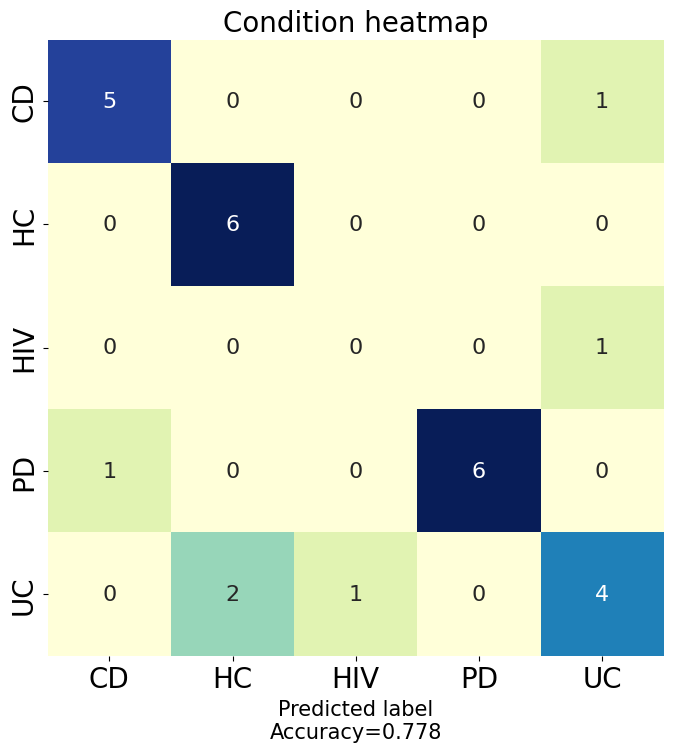

In [57]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.841                0.088              0.827   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.079          0.827         0.079                 0.906   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.028              0.906             0.028          0.906   

   f1_micro_std  accuray_mean  accuray_std  
0         0.028         0.906        0.028  
[[6 0 0 0 0]
 [0 6 1 0 0]
 [0 0 0 0 1]
 [0 0 0 7 0]
 [0 0 0 0 6]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 1 0 0]
 [0 0 0 0 1]
 [0 0 0 7 0]
 [0 0 0 0 6]]


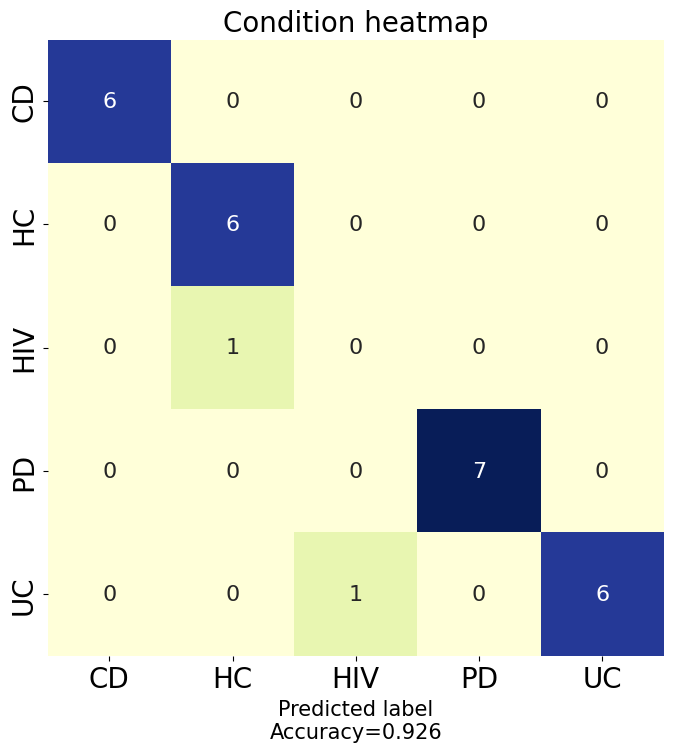

In [58]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [94]:
##Baseline data
#Using 10 dimensions
problem='5_conditions'
data_type='baseline_RMP_10'
data = data_baseline_top_10_dimensions


#Specify the columns you want
end_index=-1
start_index=8

###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)

###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()



<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataC

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.872                0.114              0.852   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.083          0.852         0.093                 0.935   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.028              0.935             0.028          0.935   

   f1_micro_std  accuray_mean  accuray_std  
0         0.028         0.935        0.028  
[[5 0 0 0 1]
 [0 6 1 0 0]
 [0 0 0 0 0]
 [0 0 0 7 0]
 [1 0 0 0 6]]
[0.83333333 0.         0.         0.         0.16666667]
[[5 0 0 0 1]
 [0 6 1 0 0]
 [0 0 0 0 0]
 [0 0 0 7 0]
 [1 0 0 0 6]]


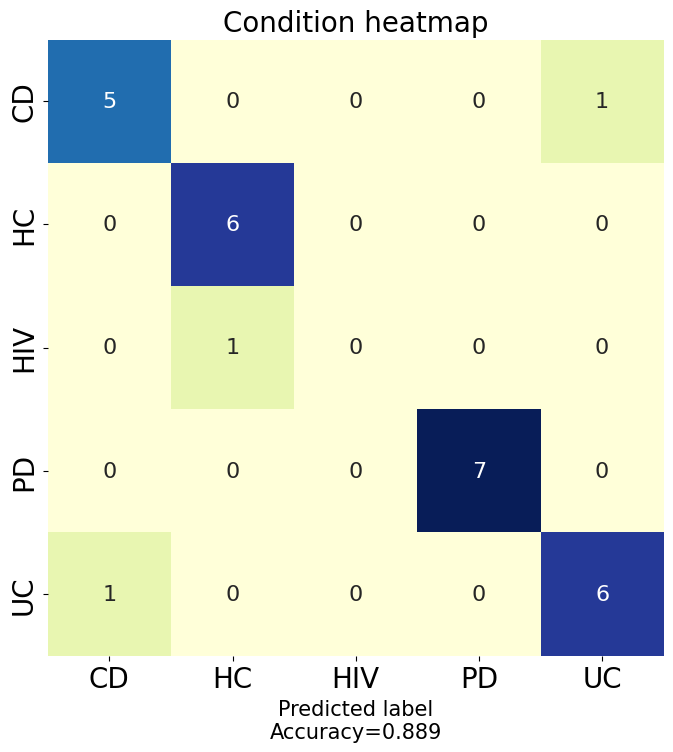

In [53]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.984                0.022              0.968   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.048          0.971         0.044                 0.979   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.029              0.979             0.029          0.979   

   f1_micro_std  accuray_mean  accuray_std  
0         0.029         0.979        0.029  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]


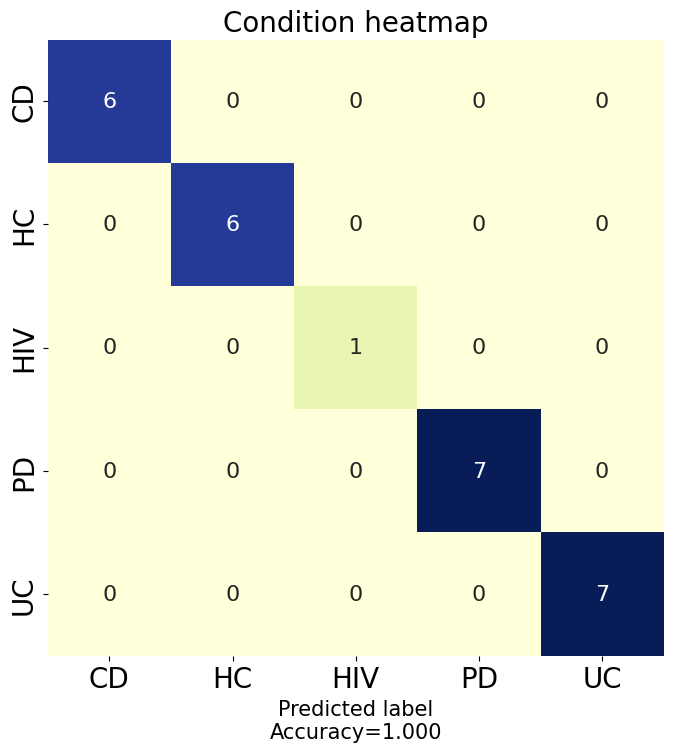

In [54]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [95]:
##Baseline data
#Using 15 dimensions
problem='5_conditions'
data_type='baseline_RMP_15'
data = data_baseline_top_15_dimensions


#Specify the columns you want
end_index=-1
start_index=8

###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)

###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()



<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataC

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.848                0.111              0.823   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.076          0.825         0.087                 0.906   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.018              0.906             0.018          0.906   

   f1_micro_std  accuray_mean  accuray_std  
0         0.018         0.906        0.018  
[[5 0 0 0 1]
 [0 6 1 0 0]
 [0 0 0 0 0]
 [0 0 0 7 0]
 [1 0 0 0 6]]
[0.83333333 0.         0.         0.         0.16666667]
[[5 0 0 0 1]
 [0 6 1 0 0]
 [0 0 0 0 0]
 [0 0 0 7 0]
 [1 0 0 0 6]]


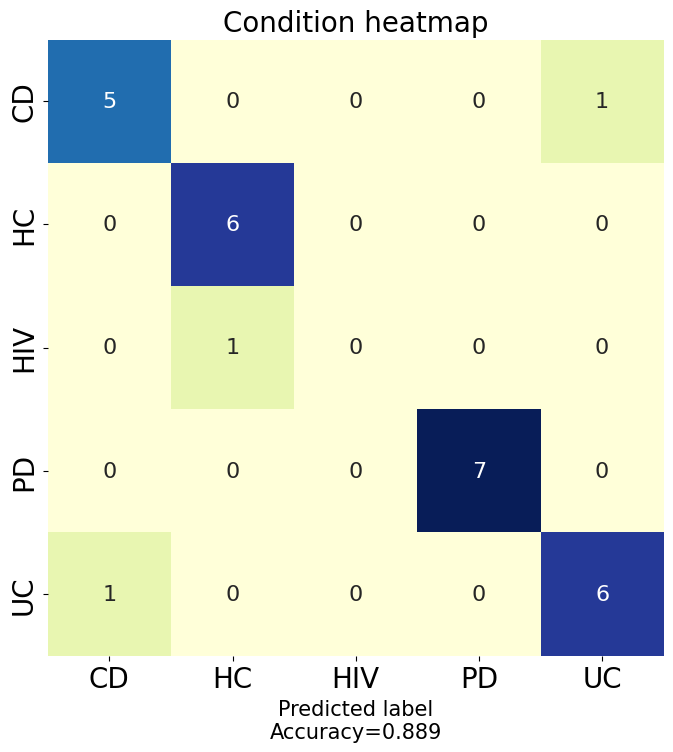

In [45]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.974                0.023              0.942   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.051          0.948         0.046                 0.964   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.032              0.964             0.032          0.964   

   f1_micro_std  accuray_mean  accuray_std  
0         0.032         0.964        0.032  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]


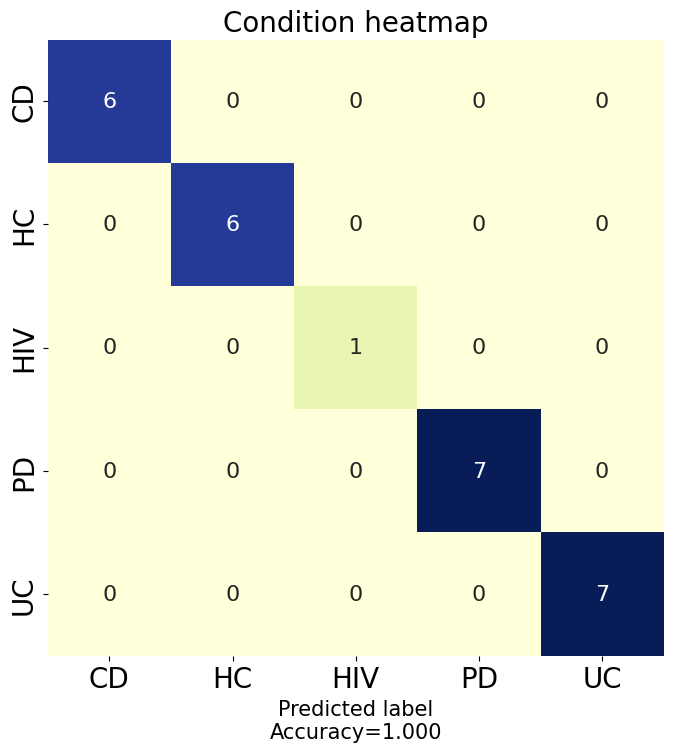

In [46]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [96]:
##Fiber data
problem='5_conditions'
data_type='fiber_RMP_5'
data = data_fiber_top_5_dimensions

#Specify the columns you want
end_index=-1
start_index=8


###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)


###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()



<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.835                0.059              0.786   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.053          0.796         0.053                 0.849   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.035              0.849             0.035          0.849   

   f1_micro_std  accuray_mean  accuray_std  
0         0.035         0.849        0.035  
[[34  3  0  5  3]
 [ 2 48  3  3  4]
 [ 0  1  4  0  0]
 [ 1  5  2 55  2]
 [ 1  1  0  6 35]]
[0.75555556 0.06666667 0.         0.11111111 0.06666667]
[[34  3  0  5  3]
 [ 2 48  3  3  4]
 [ 0  1  4  0  0]
 [ 1  5  2 55  2]
 [ 1  1  0  6 35]]


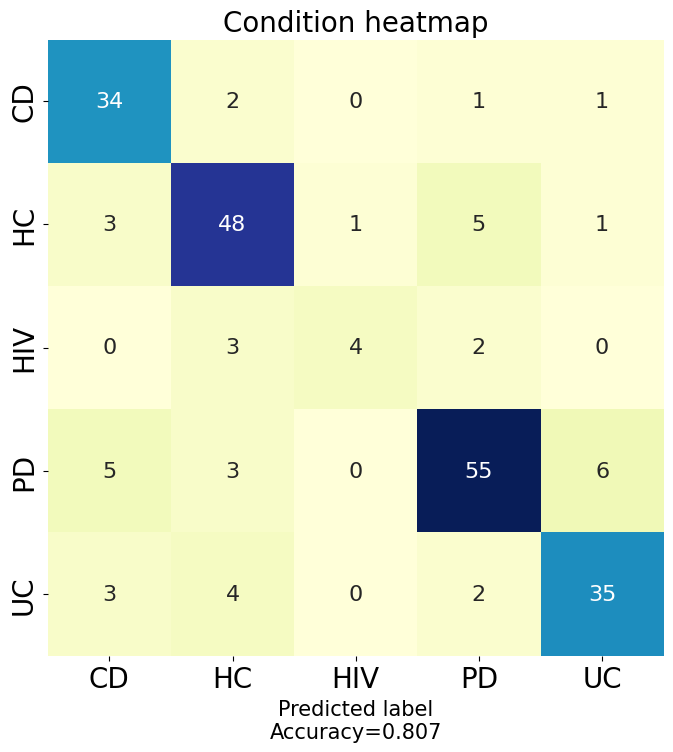

In [97]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.774                0.049              0.762   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0              0.04          0.759         0.033                 0.792   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.021              0.792             0.021          0.792   

   f1_micro_std  accuray_mean  accuray_std  
0         0.021         0.792        0.021  
[[35  2  0  3  4]
 [ 1 44  2  5  4]
 [ 0  0  5  0  0]
 [ 0  4  2 54  1]
 [ 2  8  0  7 35]]
[0.79545455 0.04545455 0.         0.06818182 0.09090909]
[[35  2  0  3  4]
 [ 1 44  2  5  4]
 [ 0  0  5  0  0]
 [ 0  4  2 54  1]
 [ 2  8  0  7 35]]


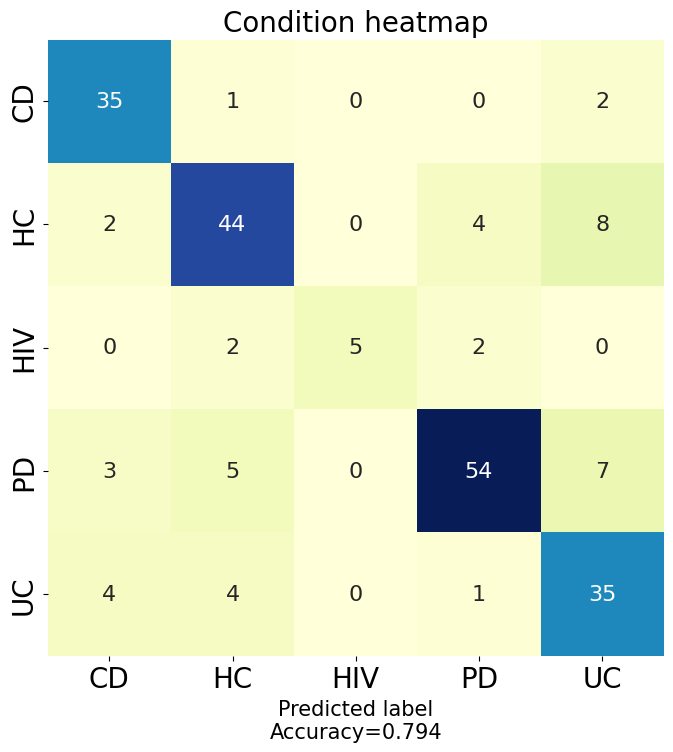

In [98]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [99]:
##Fiber data
problem='5_conditions'
data_type='fiber_RMP_10'
data = data_fiber_top_10_dimensions

#Specify the columns you want
end_index=-1
start_index=8


###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)


###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()



<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.931                0.037              0.907   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.042          0.914          0.04                  0.93   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                 0.02               0.93              0.02           0.93   

   f1_micro_std  accuray_mean  accuray_std  
0          0.02          0.93         0.02  
[[36  3  0  2  0]
 [ 0 54  2  1  0]
 [ 0  0  6  0  0]
 [ 0  1  1 64  0]
 [ 2  0  0  2 44]]
[0.87804878 0.07317073 0.         0.04878049 0.        ]
[[36  3  0  2  0]
 [ 0 54  2  1  0]
 [ 0  0  6  0  0]
 [ 0  1  1 64  0]
 [ 2  0  0  2 44]]


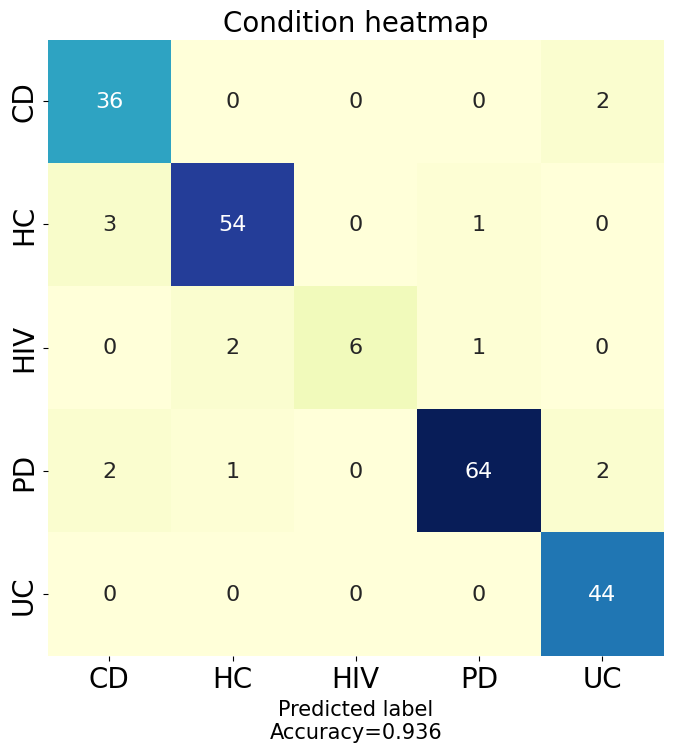

In [100]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.931                0.048              0.946   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.022          0.933         0.034                 0.951   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.019              0.951             0.019          0.951   

   f1_micro_std  accuray_mean  accuray_std  
0         0.019         0.951        0.019  
[[37  1  0  0  0]
 [ 0 56  0  1  0]
 [ 0  0  7  0  0]
 [ 0  0  2 66  0]
 [ 1  1  0  2 44]]
[0.97368421 0.02631579 0.         0.         0.        ]
[[37  1  0  0  0]
 [ 0 56  0  1  0]
 [ 0  0  7  0  0]
 [ 0  0  2 66  0]
 [ 1  1  0  2 44]]


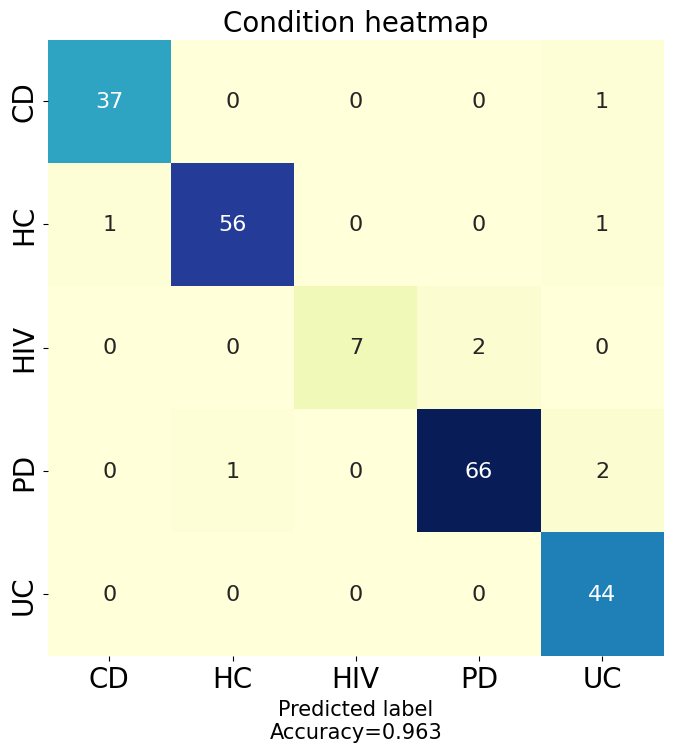

In [101]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [102]:
##Fiber data
problem='5_conditions'
data_type='fiber_RMP_15'
data = data_fiber_top_15_dimensions

#Specify the columns you want
end_index=-1
start_index=8


###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)


###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()



<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.958                0.012              0.906   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.055          0.923         0.046                 0.949   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.017              0.949             0.017          0.949   

   f1_micro_std  accuray_mean  accuray_std  
0         0.017         0.949        0.017  
[[36  0  0  2  0]
 [ 0 57  0  0  1]
 [ 0  0  7  0  0]
 [ 1  1  2 67  0]
 [ 1  0  0  0 43]]
[0.94736842 0.         0.         0.05263158 0.        ]
[[36  0  0  2  0]
 [ 0 57  0  0  1]
 [ 0  0  7  0  0]
 [ 1  1  2 67  0]
 [ 1  0  0  0 43]]


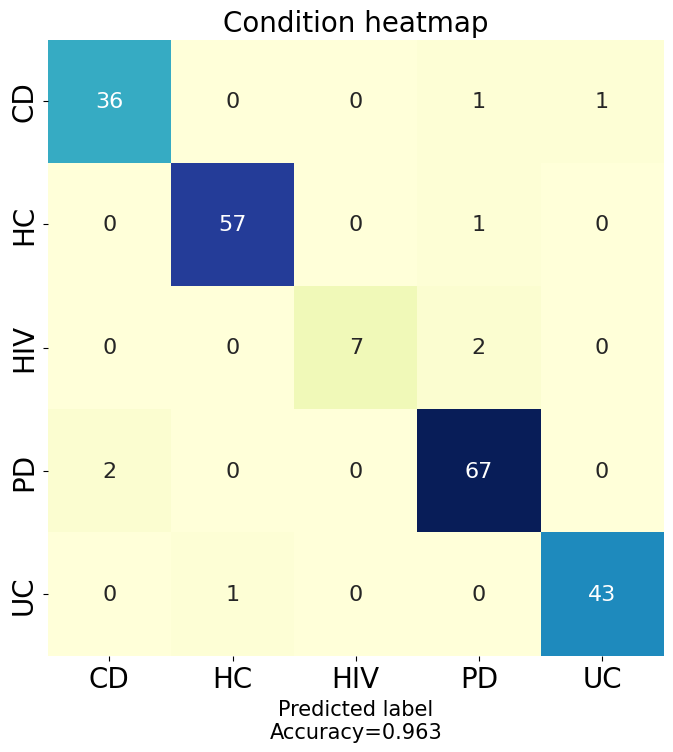

In [103]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.966                0.024              0.961   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.024          0.961          0.02                 0.972   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.011              0.972             0.011          0.972   

   f1_micro_std  accuray_mean  accuray_std  
0         0.011         0.972        0.011  
[[34  0  0  1  0]
 [ 0 58  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  2 68  0]
 [ 4  0  0  0 44]]
[0.97142857 0.         0.         0.02857143 0.        ]
[[34  0  0  1  0]
 [ 0 58  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  2 68  0]
 [ 4  0  0  0 44]]


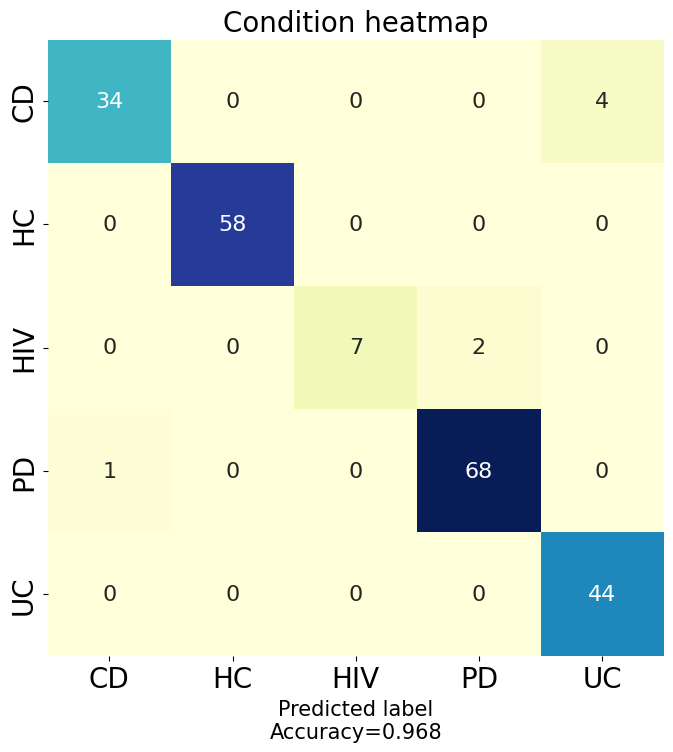

In [104]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


**2) classifying 5 conditions with PCA**

In [105]:
##Baseline data
problem='5_conditions'
data_type='baseline_PCA_5'
data = data_baseline_PCA_5


#Specify the columns you want
end_index=-1
start_index=8


###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)

###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()


<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                  0.74                0.103              0.746   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.084          0.736         0.095                 0.884   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.035              0.884             0.035          0.884   

   f1_micro_std  accuray_mean  accuray_std  
0         0.035         0.884        0.035  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 0 0 0]
 [0 0 0 7 2]
 [0 0 1 0 5]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 0 0 0]
 [0 0 0 7 2]
 [0 0 1 0 5]]


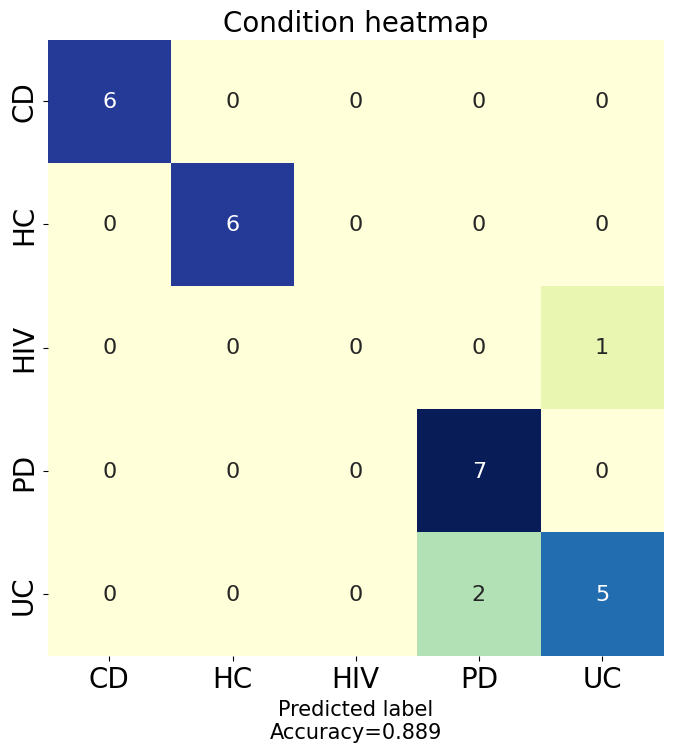

In [106]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.948                0.052              0.933   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0              0.06          0.934         0.059                 0.943   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.048              0.943             0.048          0.943   

   f1_micro_std  accuray_mean  accuray_std  
0         0.048         0.943        0.048  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 1]
 [0 0 0 0 6]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 1]
 [0 0 0 0 6]]


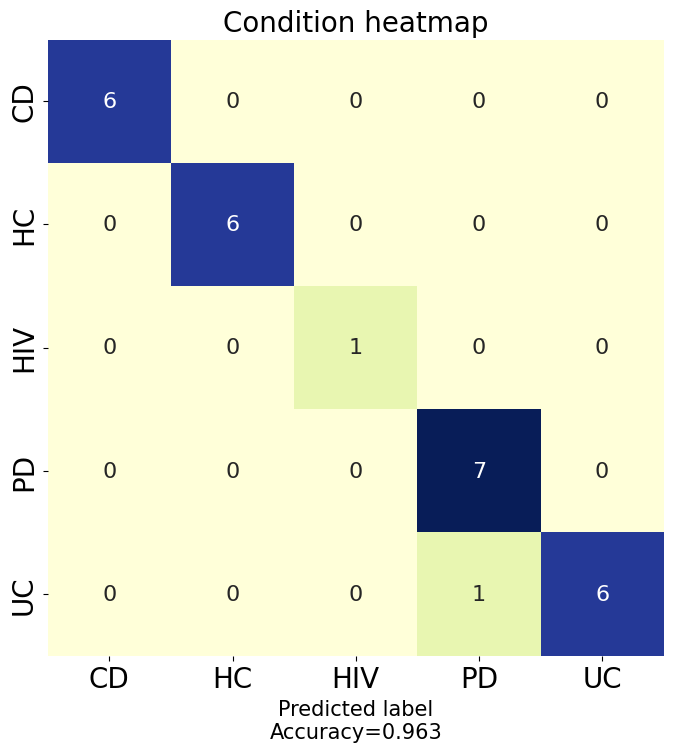

In [107]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [108]:
##Baseline data
problem='5_conditions'
data_type='baseline_PCA_10'
data = data_baseline_PCA_10


#Specify the columns you want
end_index=-1
start_index=8


###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)

###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()


<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataC

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.895                0.096              0.882   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0              0.07          0.883         0.079                 0.964   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.001              0.964             0.001          0.964   

   f1_micro_std  accuray_mean  accuray_std  
0         0.001         0.964        0.001  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 0 0 0]
 [0 0 0 7 0]
 [0 0 1 0 7]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 0 0 0]
 [0 0 0 7 0]
 [0 0 1 0 7]]


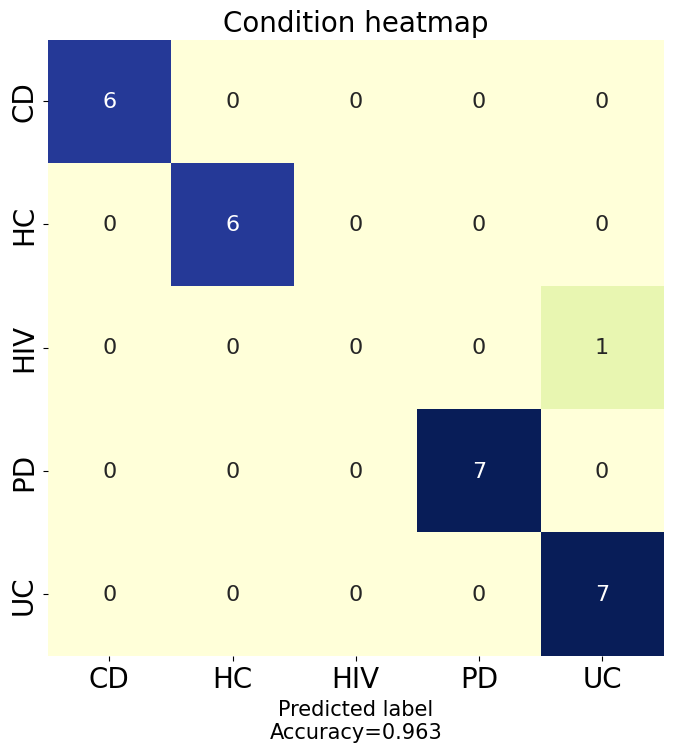

In [109]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                  0.98                0.017              0.959   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.038          0.964         0.032                 0.978   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.018              0.978             0.018          0.978   

   f1_micro_std  accuray_mean  accuray_std  
0         0.018         0.978        0.018  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]


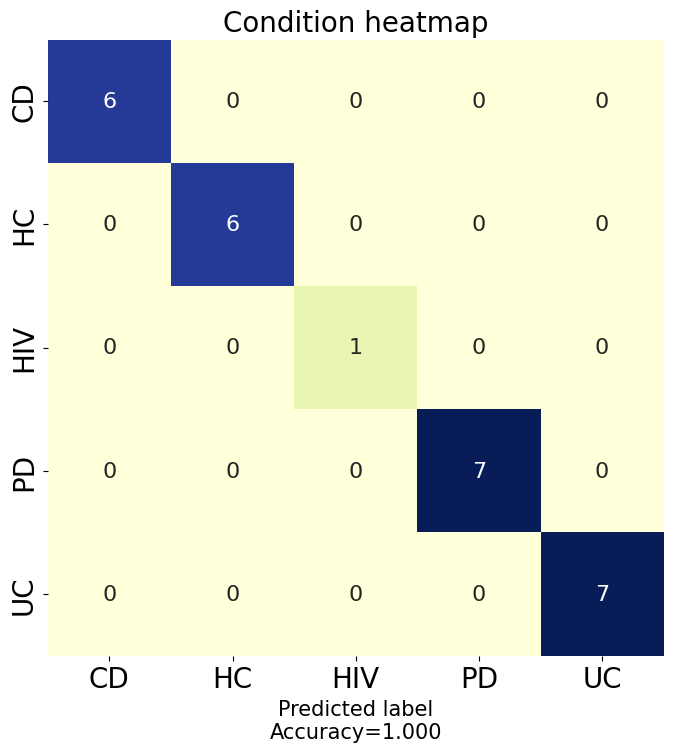

In [110]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [112]:
##Baseline data
problem='5_conditions'
data_type='baseline_PCA_15'
data = data_baseline_PCA_15


#Specify the columns you want
end_index=-1
start_index=8


###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)

###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()


<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.978                0.021              0.964   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.046          0.965         0.042                 0.971   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.027              0.971             0.027          0.971   

   f1_micro_std  accuray_mean  accuray_std  
0         0.027         0.971        0.027  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 1]
 [0 0 0 0 6]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 1]
 [0 0 0 0 6]]


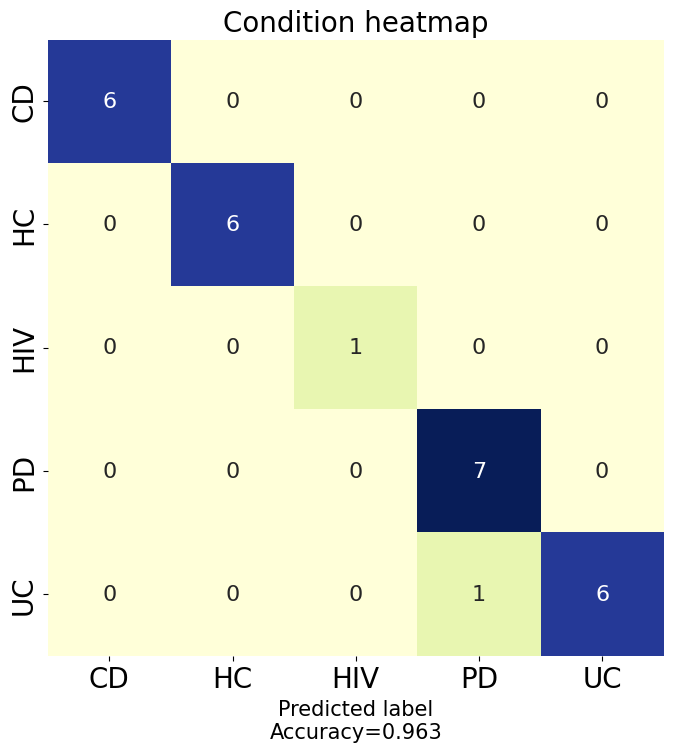

In [113]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                  0.98                0.017              0.959   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.038          0.964         0.032                 0.978   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.018              0.978             0.018          0.978   

   f1_micro_std  accuray_mean  accuray_std  
0         0.018         0.978        0.018  
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]
[1. 0. 0. 0. 0.]
[[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 1 0 0]
 [0 0 0 7 0]
 [0 0 0 0 7]]


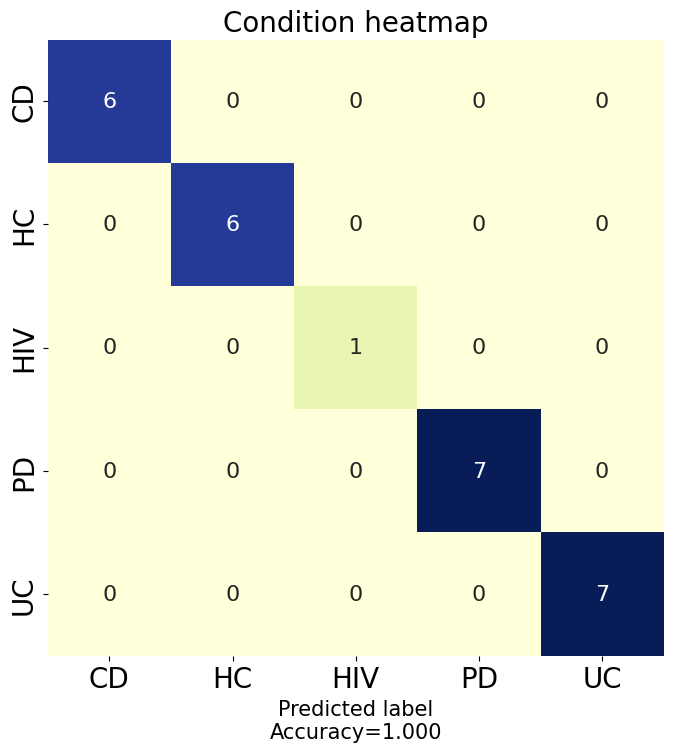

In [114]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [115]:
##Fiber data
problem='5_conditions'
data_type='fiber_PCA_5'
data = data_fiber_PCA_5


#Specify the columns you want
end_index=-1
start_index=8


###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)

###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()


<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.882                0.034              0.816   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.077          0.832         0.065                 0.856   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.029              0.856             0.029          0.856   

   f1_micro_std  accuray_mean  accuray_std  
0         0.029         0.856        0.029  
[[31  0  0  1  2]
 [ 2 54  3  6  4]
 [ 0  0  3  0  0]
 [ 3  3  3 60  3]
 [ 2  1  0  2 35]]
[0.91176471 0.         0.         0.02941176 0.05882353]
[[31  0  0  1  2]
 [ 2 54  3  6  4]
 [ 0  0  3  0  0]
 [ 3  3  3 60  3]
 [ 2  1  0  2 35]]


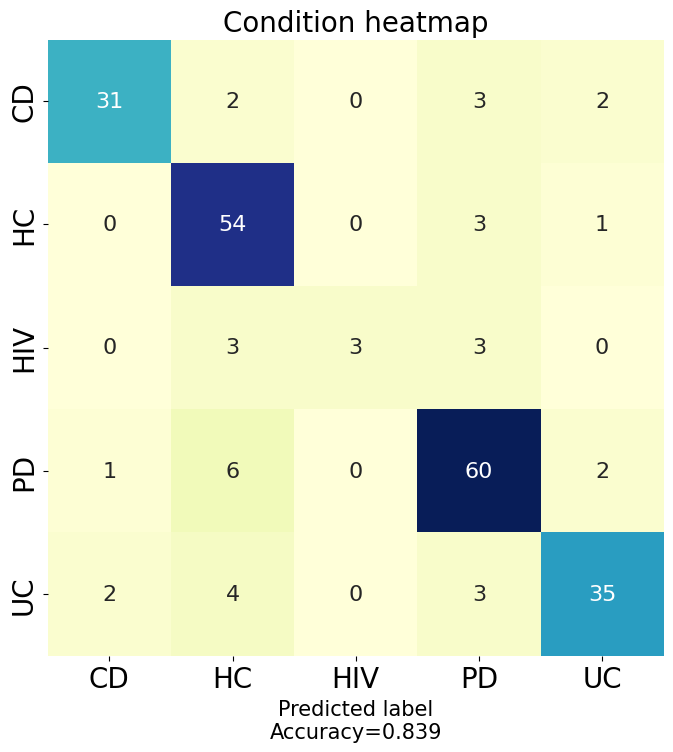

In [116]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.844                0.024              0.795   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.043           0.81          0.04                 0.818   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.018              0.818             0.018          0.818   

   f1_micro_std  accuray_mean  accuray_std  
0         0.018         0.818        0.018  
[[30  0  0  4  2]
 [ 2 49  1 10  2]
 [ 0  0  7  2  0]
 [ 3  6  1 52  3]
 [ 3  3  0  1 37]]
[0.83333333 0.         0.         0.11111111 0.05555556]
[[30  0  0  4  2]
 [ 2 49  1 10  2]
 [ 0  0  7  2  0]
 [ 3  6  1 52  3]
 [ 3  3  0  1 37]]


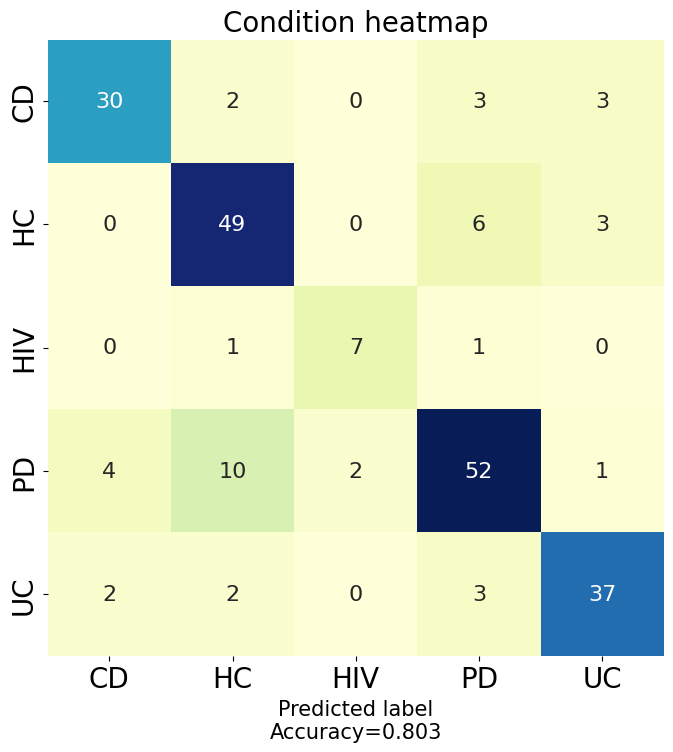

In [117]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [118]:
##PCA 10 dimensions

problem='5_conditions'
data_type='fiber_PCA_10'
data = data_fiber_PCA_10


#Specify the columns you want
end_index=-1
start_index=8

###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)


###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()


<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.962                0.017               0.93   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.042          0.942         0.032                 0.954   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                 0.02              0.954              0.02          0.954   

   f1_micro_std  accuray_mean  accuray_std  
0          0.02         0.954         0.02  
[[35  0  0  1  0]
 [ 0 56  1  0  3]
 [ 0  0  6  0  0]
 [ 0  2  2 67  0]
 [ 3  0  0  1 41]]
[0.97222222 0.         0.         0.02777778 0.        ]
[[35  0  0  1  0]
 [ 0 56  1  0  3]
 [ 0  0  6  0  0]
 [ 0  2  2 67  0]
 [ 3  0  0  1 41]]


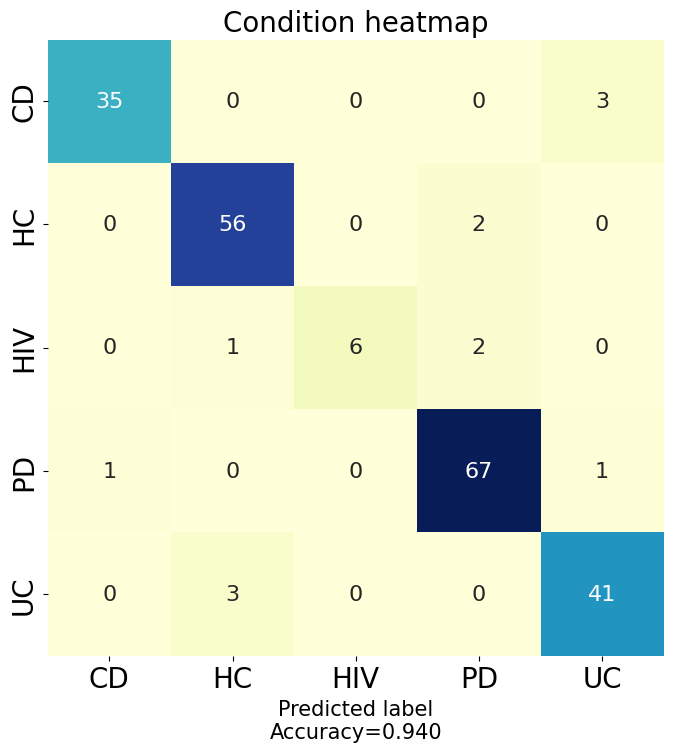

In [73]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.977                0.008              0.965   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.016           0.97         0.012                 0.972   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.009              0.972             0.009          0.972   

   f1_micro_std  accuray_mean  accuray_std  
0         0.009         0.972        0.009  
[[36  0  0  0  0]
 [ 0 58  2  3  0]
 [ 0  0  7  0  0]
 [ 0  0  0 66  0]
 [ 2  0  0  0 44]]
[1. 0. 0. 0. 0.]
[[36  0  0  0  0]
 [ 0 58  2  3  0]
 [ 0  0  7  0  0]
 [ 0  0  0 66  0]
 [ 2  0  0  0 44]]


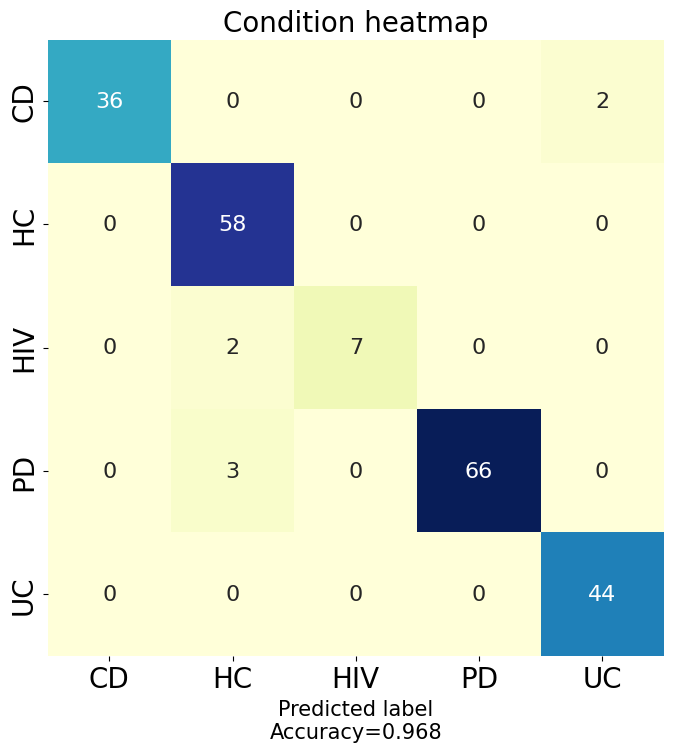

In [119]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


In [120]:
##PCA 10 dimensions

problem='5_conditions'
data_type='fiber_PCA_15'
data = data_fiber_PCA_15


#Specify the columns you want
end_index=-1
start_index=8

###Creating an intance of the classifier class
instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)


###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()


<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-9-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.972                0.014              0.954   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.027          0.961         0.021                 0.966   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.016              0.966             0.016          0.966   

   f1_micro_std  accuray_mean  accuray_std  
0         0.016         0.966        0.016  
[[35  0  0  0  0]
 [ 0 58  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  2 69  0]
 [ 3  0  0  0 44]]
[1. 0. 0. 0. 0.]
[[35  0  0  0  0]
 [ 0 58  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  2 69  0]
 [ 3  0  0  0 44]]


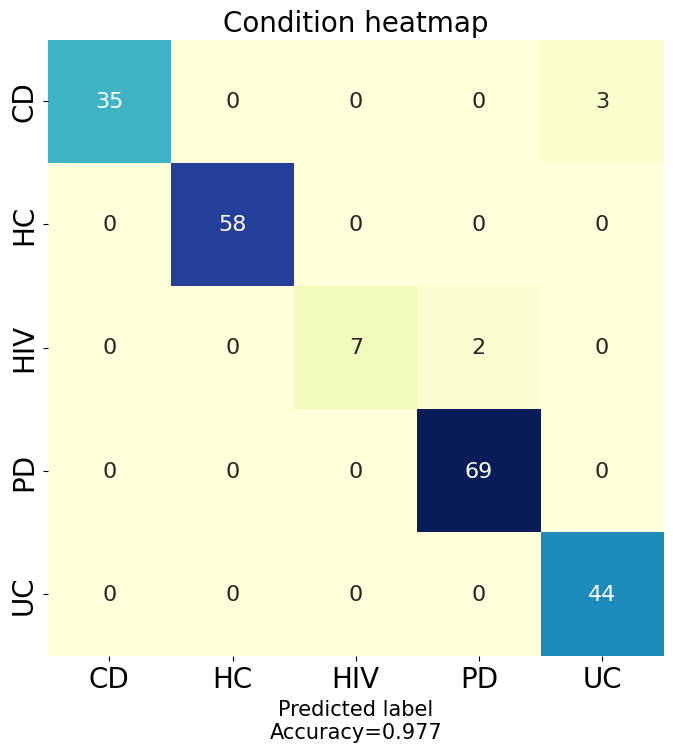

In [121]:
####Using RF method
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.984                0.009              0.972   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.022          0.977         0.016                 0.981   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                 0.01              0.981              0.01          0.981   

   f1_micro_std  accuray_mean  accuray_std  
0          0.01         0.981         0.01  
[[35  0  0  0  1]
 [ 0 58  1  0  0]
 [ 0  0  7  0  0]
 [ 0  0  1 69  0]
 [ 3  0  0  0 43]]
[0.97222222 0.         0.         0.         0.02777778]
[[35  0  0  0  1]
 [ 0 58  1  0  0]
 [ 0  0  7  0  0]
 [ 0  0  1 69  0]
 [ 3  0  0  0 43]]


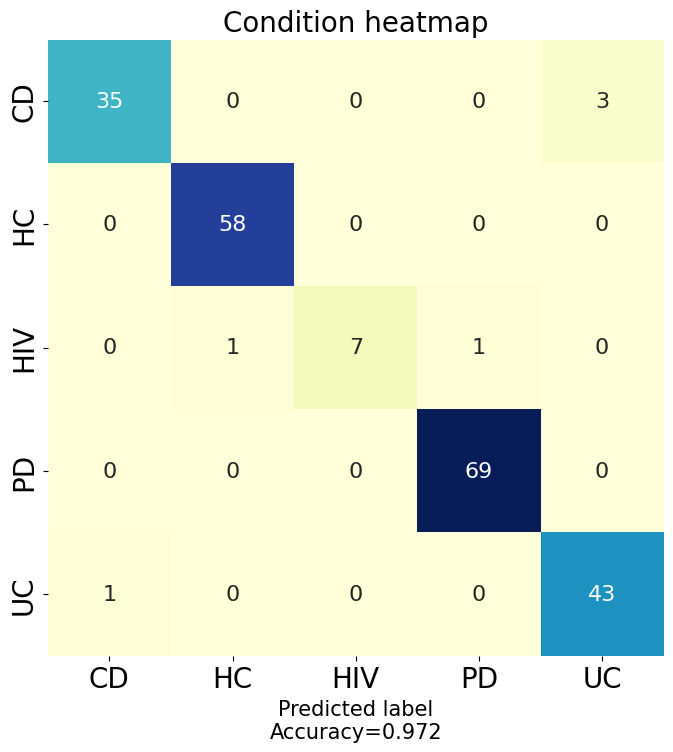

In [122]:
####Using SVM method
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))
